# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [62]:
import os
import sys
import glob
import random
import math
import re
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json

from config import Config
import utils
import model as modellib
import visualize
from model import log
from pycocotools import mask as maskUtils

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [2]:
MODEL_DIR

'/Users/shangyingao/Documents/python/cs231n/final_project/WWGH/logs'

## Configurations

In [64]:
class CityscapeConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cityscape_data"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes
    NUM_CLASSES = 30

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 2048

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 200  # default value

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1000  # small number on small dataset, better smaller than 1000

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50  # bigger number improves validation stats accuracy but slows down
    
config = CityscapeConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[512 512]
 [256 256]
 [128 128]
 [ 64  64]
 [ 32  32]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  2048
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [2048 2048    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           cityscape_data
NUM_CLASSES                    30
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TR

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [42]:
a = {'aa':1, 'bb':2}
list(a.keys())[1]

'aa'

In [5]:
CITY_DIR = "../cityscape_dataset/"

In [65]:
class CityscapesDataset(utils.Dataset):    
    def load_cityscapes(self, dataset_dir, subset):
        """Load a subset of the cityscapes dataset.
        dataset_dir: The root directory of the cityscapes dataset.
        subset: What to load (train, val, test)
        """
        self.class_labels = {
        'unlabeled':0,
        'ego vehicle':1,        
        'rectification border':2,
        'out of roi':3,           
        'static':4,               
        'dynamic':5,              
        'ground':6,               
        'road':7,                 
        'sidewalk':8,             
        'parking':9,              
        'rail track':10,           
        'building':11,            
        'wall':12,                 
        'fence':13,                
        'guard rail':14,           
        'bridge':15,               
        'tunnel':16,               
        'pole':17,                 
        'polegroup':18,            
        'traffic light':19,        
        'traffic sign':20,         
        'vegetation':21,           
        'terrain':22,              
        'sky':23,                  
        'person':24,               
        'rider':25,                
        'car':26,                  
        'truck':27,                
        'bus':28,                  
        'caravan':29,              
        'trailer':30,              
        'train':31,                
        'motorcycle':32,           
        'bicycle':33,              
        'license plate':34}

#         image_dir = "{}/{}/{}".format(dataset_dir, "images", subset)
#         annotation_dir = "{}/{}/{}".format(dataset_dir, "annotations", subset)
        
        annotation_dir = dataset_dir + 'gtFine_trainvaltest/' + subset + '_all.json'
        self.image_info = json.load(open(annotation_dir, 'r'))

        # All images within the folder
#         num_images = len(glob.glob('*'))
#         image_ids = range(num_images)
        
        # Add classes
        for i in range(len(self.class_labels)):
            self.add_class("cityscape", i, list(self.class_labels.keys())[i])
            
        # Add images
#         for i in image_ids:
#             self.add_image(
#                 # "cityscapes", 
#                 image_id=i,
#                 # path=os.path.join(image_dir, coco.imgs[i]['file_name']),
#                 width=coco.imgs[i]["width"],
#                 height=coco.imgs[i]["height"],
#                 annotations=coco.loadAnns(coco.getAnnIds(
#                     imgIds=[i], catIds=class_ids, iscrowd=None)))
    
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        pass
    
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # TODO: build dict **self.image_info** in this form
        # self.image_info.keys() = ['objects', 'imgWidth', 'imgHeight']
        # objects is a list which contains label and polygon (same as annotations form below)
        # imgHeight and imgWidth are numbers (usually 1024, 2048)
        annotations = self.image_info[image_id]["objects"]
        # annotations form: [{'label': label, 'polygon': [[x1,y1], [x2,y2] ...]}, ...]
        height = self.image_info[image_id]['imgHeight']
        width = self.image_info[image_id]['imgWidth']
        instance_masks = []
        class_ids = []
        for ann in annotations:
            m = self.annToMask(ann, height, width)
            
            label_tmp = ann['label']
            if ( not label_tmp in list(self.class_labels.keys()) ) and label_tmp.endswith('group'):
                label_tmp = label_tmp[:-len('group')]
            
            class_id = self.class_labels[label_tmp]
            instance_masks.append(m)
            class_ids.append(class_id)
            
        mask = np.stack(instance_masks, axis=2)
        class_ids = np.array(class_ids)
        
        return mask, class_ids
        
    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentaion']
        # convert segm from [[x1, y1], [x2, y2]...] to [[x1, y1, x2, y2, ...]] 
        segm = [np.ravel(segm)]
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentaion']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m


In [66]:
# Training dataset
dataset_train = CityscapesDataset()
dataset_train.load_cityscapes(CITY_DIR, 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = CityscapesDataset()
dataset_val.load_cityscapes(CITY_DIR, 'val')
dataset_val.prepare()

In [84]:
dataset_train.class_labels

['unlabeled',
 'ego vehicle',
 'rectification border',
 'out of roi',
 'static',
 'dynamic',
 'ground',
 'road',
 'sidewalk',
 'parking',
 'rail track',
 'building',
 'wall',
 'fence',
 'guard rail',
 'bridge',
 'tunnel',
 'pole',
 'polegroup',
 'traffic light',
 'traffic sign',
 'vegetation',
 'terrain',
 'sky',
 'person',
 'rider',
 'car',
 'truck',
 'bus',
 'caravan',
 'trailer',
 'train',
 'motorcycle',
 'bicycle',
 'license plate']

In [63]:
for idx in range(len(dataset_train.image_info)):
    if dataset_train.image_info[idx]['image_id'] == 'bremen_000240_000019':
        print(idx)

2842


In [48]:
dataset_train.image_info[2842]

{'image_id': 'bremen_000240_000019',
 'imgHeight': 1024,
 'imgWidth': 2048,
 'objects': [{'label': 'sky',
   'segmentaion': [[102, 1], [1337, 0], [1194, 339], [458, 384]]},
  {'label': 'road',
   'segmentaion': [[686, 451],
    [800, 453],
    [949, 465],
    [1403, 684],
    [1897, 796],
    [2048, 809],
    [2048, 1024],
    [1, 1024],
    [0, 554],
    [359, 520],
    [625, 473]]},
  {'label': 'vegetation',
   'segmentaion': [[883, 270],
    [878, 260],
    [881, 256],
    [872, 254],
    [877, 248],
    [879, 245],
    [878, 243],
    [874, 240],
    [874, 232],
    [880, 229],
    [880, 223],
    [883, 216],
    [883, 214],
    [886, 206],
    [890, 203],
    [893, 204],
    [895, 201],
    [895, 199],
    [905, 196],
    [907, 196],
    [921, 194],
    [931, 190],
    [940, 190],
    [944, 196],
    [951, 196],
    [957, 194],
    [964, 193],
    [975, 192],
    [983, 191],
    [989, 190],
    [999, 189],
    [1003, 189],
    [1012, 190],
    [1013, 197],
    [1016, 200],
    [10

In [54]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

TypeError: list indices must be integers or slices, not numpy.str_

## Ceate Model

In [67]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [68]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.


2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [21]:
dataset_train.class_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [69]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/shangyingao/Documents/python/cs231n/final_project/WWGH/logs/cityscape_data20180126T2130/mask_rcnn_cityscape_data_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistribu

/Users/shangyingao/anaconda3/envs/dl4cv/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/shangyingao/anaconda3/envs/dl4cv/lib/python3.5/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


******************************************************
******************************************************
/Users/shangyingao/Documents/python/cs231n/final_project/cityscape_dataset/images/train/hanover/hanover_000000_013205_leftImg8bit.png
/Users/shangyingao/Documents/python/cs231n/final_project/cityscape_dataset/images/train/zurich/zurich_000034_000019_leftImg8bit.png
Epoch 1/1
******************************************************
/Users/shangyingao/Documents/python/cs231n/final_project/cityscape_dataset/images/train/hamburg/hamburg_000000_069177_leftImg8bit.png
******************************************************
/Users/shangyingao/Documents/python/cs231n/final_project/cityscape_dataset/images/train/monchengladbach/monchengladbach_000000_031005_leftImg8bit.png
******************************************************
/Users/shangyingao/Documents/python/cs231n/final_project/cityscape_dataset/images/train/aachen/aachen_000042_000019_leftImg8bit.png
*********************************

Process Process-11:
Process Process-12:
Traceback (most recent call last):
  File "/Users/shangyingao/anaconda3/envs/dl4cv/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/Users/shangyingao/anaconda3/envs/dl4cv/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/shangyingao/anaconda3/envs/dl4cv/lib/python3.5/site-packages/keras/utils/data_utils.py", line 635, in data_generator_task
    generator_output = next(self._generator)
  File "/Users/shangyingao/Documents/python/cs231n/final_project/WWGH/model.py", line 1604, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/Users/shangyingao/Documents/python/cs231n/final_project/WWGH/model.py", line 1181, in load_image_gt
    bbox = utils.extract_bboxes(mask)
  File "/Users/shangyingao/Documents/python/cs231n/final_project/WWGH/utils.py", line 41, in extract_bboxes
    vertical_indicies = np.where(np.any(m, axis=1))[0]


KeyboardInterrupt: 

In [66]:
dataset_train.image_ids

array([   0,    1,    2, ..., 2972, 2973, 2974])

In [67]:
len(dataset_train.image_info)

2975

In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
Starting at epoch 0. LR=0.0002

Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 86s - loss: 11.4006 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1977 - val_loss: 11.4376 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 1.0068 - val_mrcnn_class_loss: 0.1172 - val_mrcnn_bbox_loss: 0.0683 - val_mrcnn_mask_loss: 0.1278


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(CityscapeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

original_image           shape: (128, 128, 3)         min:  108.00000  max:  236.00000
image_meta               shape: (12,)                 min:    0.00000  max:  128.00000
gt_bbox                  shape: (2, 5)                min:    2.00000  max:  102.00000
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000


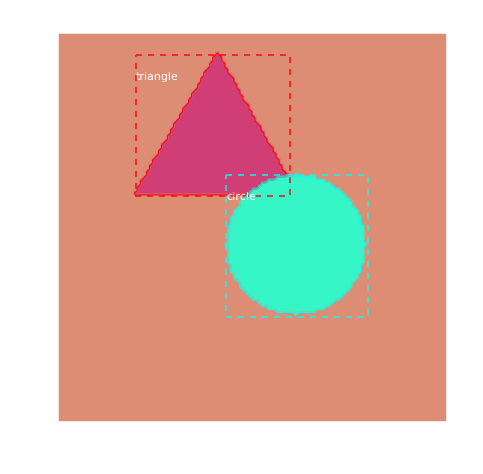

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:  108.00000  max:  236.00000
molded_images            shape: (1, 128, 128, 3)      min:  -15.70000  max:  132.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


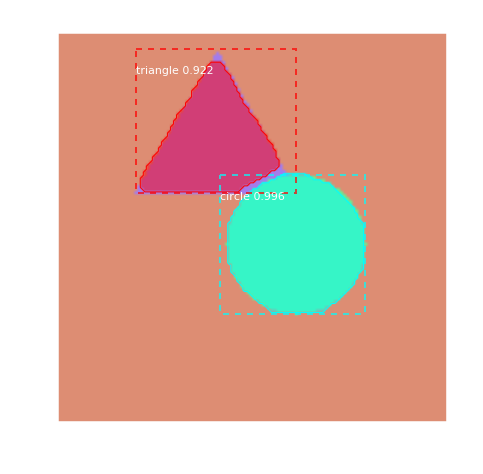

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95
